In [0]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
il = ImageList.from_folder(path_hr)

This is similar to the GAN notebook, but we're not writing text on the images, and the JPEG quality is always 60.

In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [5]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /root/.fastai/data/oxford-iiit-pet/small-96


resizing to 256 into /root/.fastai/data/oxford-iiit-pet/small-256


In [6]:
!ls {path_lr} | head

Abyssinian_100.jpg
Abyssinian_101.jpg
Abyssinian_102.jpg
Abyssinian_103.jpg
Abyssinian_104.jpg
Abyssinian_105.jpg
Abyssinian_106.jpg
Abyssinian_107.jpg
Abyssinian_108.jpg
Abyssinian_109.jpg


In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

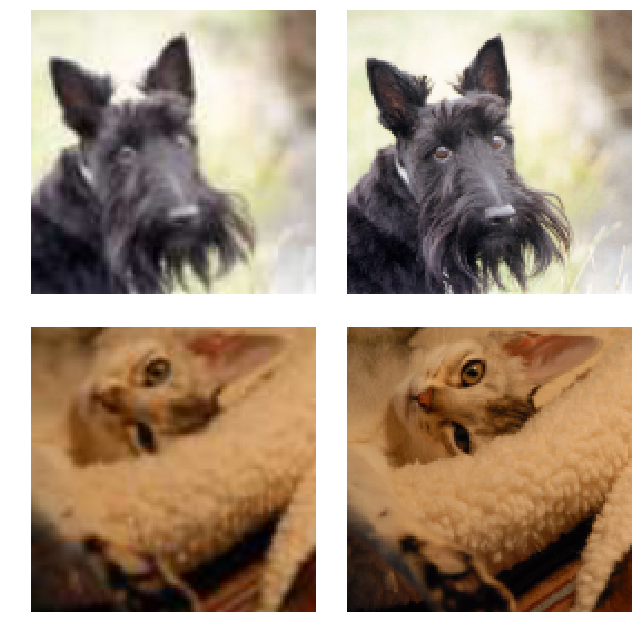

In [10]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Perceptual/Feature Loss
See the [Perceptual Losses for Real-Time Style Transfer and Super-Resolution paper](https://arxiv.org/pdf/1603.08155.pdf).

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [13]:
gram_matrix(t)

tensor([[[0.1580, 0.1535, 0.1404],
         [0.1535, 0.1494, 0.1366],
         [0.1404, 0.1366, 0.1257]],

        [[0.1580, 0.1535, 0.1404],
         [0.1535, 0.1494, 0.1366],
         [0.1404, 0.1366, 0.1257]]])

First, we define a base loss function

In [0]:
base_loss = F.l1_loss  # You could also use MSE loss

In [15]:
# .features gives the convolutional part of the model
# .eval() means we're not training it
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
553507836it [00:06, 90049172.19it/s]


Let's go through the blocks and find all the Max-Pooling layers, because that's where the grid size changes, and you need to keep track of those indices.

In [16]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        """
        m_feat is the pre-trained model that contains the features that we
        want to generate our feature loss for.
        """
        super().__init__()
        self.m_feat = m_feat
        
        # Grab all the layers for which we want the features
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        
        # We want to hook all those outputs to grab the intermediate
        # layers.
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        # This simply calls the VGG model, and go through all the stored
        # activations and grab a copy of them
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        # Grab a copy of the stored activations for both the target
        # and the inputs (which is the output of the generator)
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        
        # Compute the L1 loss
        self.feat_losses = [base_loss(input,target)]
        
        # Go through all the layers' features and get the L1 loss
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        
        
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        
        # There's a nice callback where if you put this in self.metrics, then
        # it will print out the loss amounts for you
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train U-Net

In [19]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, # the callback we mentioned
                     blur=True, norm_type=NormType.Weight)  # these 2 will be discussed in part 2
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 94090034.62it/s]


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


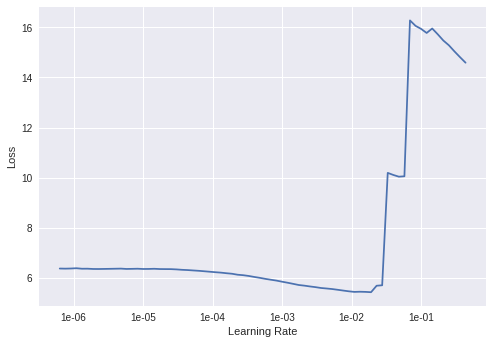

In [20]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
1,4.268022,4.130313,0.162208,0.249528,0.349360,0.243666,0.659216,1.354179,1.112157,04:12
2,3.958859,3.846056,0.150099,0.236280,0.326174,0.228822,0.593685,1.254249,1.056748,04:08
3,3.830719,3.662549,0.143753,0.229955,0.313456,0.218564,0.549902,1.194098,1.012821,04:08
4,3.746387,3.618335,0.149166,0.229663,0.310547,0.214006,0.536781,1.191077,0.987096,04:07
5,3.649440,3.465271,0.138904,0.224688,0.301014,0.207143,0.505920,1.128784,0.958819,04:07
6,3.575378,3.377867,0.139799,0.222468,0.294441,0.201544,0.483812,1.098815,0.936988,04:07
7,3.530143,3.354579,0.144459,0.221381,0.291589,0.198596,0.484717,1.093397,0.920440,04:06
8,3.480524,3.326432,0.142659,0.219331,0.290044,0.199055,0.467539,1.080560,0.927244,04:06
9,3.443702,3.225379,0.134725,0.217818,0.284528,0.192199,0.450371,1.052843,0.892896,04:06
10,3.334031,3.132365,0.132974,0.214613,0.278237,0.187307,0.428929,1.020676,0.869629,04:06


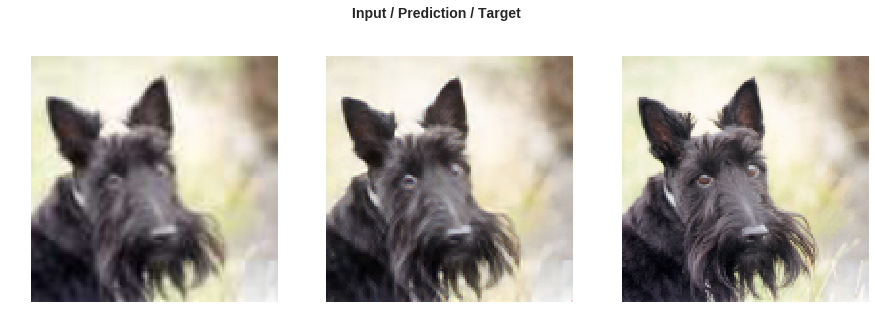

In [23]:
do_fit('1a', slice(lr))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
1,3.310136,3.122792,0.132785,0.214388,0.277282,0.186348,0.428841,1.018867,0.864281,04:17
2,3.283558,3.112163,0.132694,0.213583,0.276507,0.185706,0.427642,1.015251,0.860779,04:16
3,3.303337,3.121641,0.132478,0.213284,0.276241,0.185595,0.435503,1.016663,0.861878,04:16
4,3.303671,3.104676,0.132456,0.213513,0.276622,0.185120,0.424308,1.015539,0.857117,04:17
5,3.311162,3.121530,0.135164,0.214705,0.277817,0.185369,0.426178,1.021103,0.861194,04:16
6,3.307936,3.139930,0.135860,0.214209,0.277351,0.186486,0.434155,1.025241,0.866628,04:16
7,3.322829,3.136885,0.132436,0.213613,0.276576,0.186360,0.437056,1.024760,0.866083,04:16
8,3.331858,3.117195,0.134082,0.213961,0.276877,0.185198,0.430145,1.016968,0.859964,04:16
9,3.311748,3.118983,0.133584,0.213283,0.276672,0.184866,0.428295,1.021415,0.860868,04:16
10,3.225019,3.032005,0.130579,0.210533,0.270854,0.180711,0.408834,0.991268,0.839225,04:16


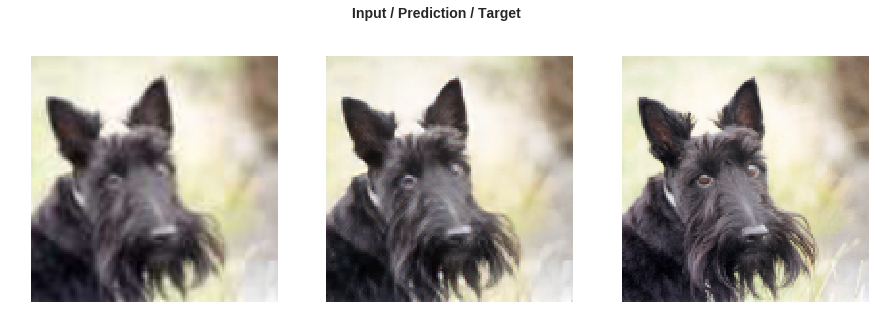

In [25]:
do_fit('1b', slice(1e-5,lr))

In [0]:
data = get_data(12,size*2)

In [27]:
learn.data = data
learn.freeze()
gc.collect()

18718

In [0]:
do_fit('2a')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
1,2.155838,2.117180,0.160214,0.257093,0.289627,0.150180,0.350741,0.561732,0.347594,17:48
2,2.140983,2.089731,0.160170,0.255509,0.286458,0.148185,0.341360,0.554163,0.343887,17:17
3,2.119507,2.081565,0.161145,0.255388,0.286129,0.147568,0.336864,0.552137,0.342335,17:17
4,2.100213,2.120303,0.172463,0.258976,0.287165,0.147895,0.343665,0.566498,0.343641,17:17
5,2.094226,2.081461,0.160359,0.252494,0.281892,0.145070,0.349635,0.552004,0.340007,17:17
6,2.124357,2.091065,0.165655,0.255946,0.285469,0.146770,0.336039,0.559510,0.341676,17:16


In [0]:
learn.unfreeze()

In [0]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## What we learned so far
![1](https://raw.githubusercontent.com/hiromis/notes/master/lesson7/45.png)